In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install py2neo

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install findspark

In [ ]:
!pip install pyspark

In [ ]:
from py2neo import Graph

In [ ]:
import pandas as pd
from numpy.random import randint

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
from sklearn.metrics import roc_curve, auc
from collections import Counter

In [ ]:
from cycler import cycler
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [ ]:
# graph = Graph("bolt://thisismatrix.centralindia.cloudapp.azure.com:7687", auth=("neo4j", "neo4j"))
graph = Graph("bolt://0.tcp.ngrok.io:15258", auth=("neo4j", "randomstufF"))

In [ ]:
# ////////////////////////////////////////////////////////////////////////////////

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [ ]:
# //////////////////////////////////just del this , just for checks
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [ ]:
len(authors_df.drop_duplicates())

63800

In [ ]:
query = """
MATCH (article:Article)
RETURN article.year AS year, count(*) AS count
ORDER BY year
"""
by_year = graph.run(query).to_data_frame()

In [ ]:
by_year = by_year[:66]

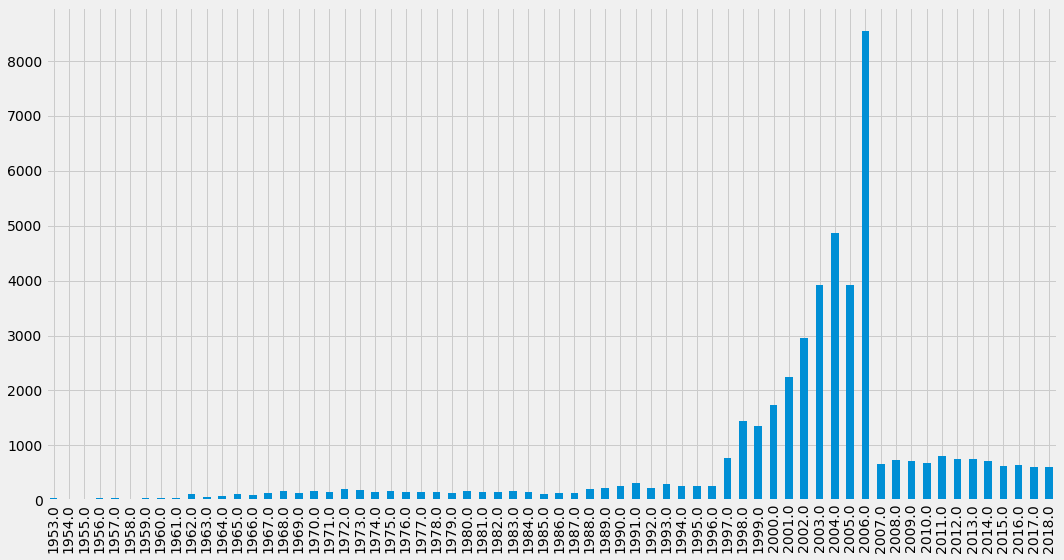

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [ ]:
# Create pipeline for fos for authors to calculate sim scores to be added to training and test sets

In [ ]:
fos_dff = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN id(n) as id, n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title
ORDER BY n.name

""").to_data_frame()

In [ ]:
fos_dff.head(5)

,id,name,fos,title
0,15040,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays
1,51863,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...
2,55909,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...
3,205176,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...
4,107172,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...


In [ ]:
def get_d(x):
    t = x.split(':')
    dict_val={}
    for i in range(len(t)):
        try:
            if(float(t[i])):
                if(t[i-1] in dict_val):
                    dict_val[t[i-1]].append(t[i])
                else:
                    dict_val[t[i-1]]=[t[i]]
        except:
            pass
    for i in dict_val:
        dict_val[i] = sorted(dict_val[i],reverse=True)
    return dict_val

In [ ]:
fos_dff['key'] = fos_dff['fos'].apply(lambda x: get_d(x))

In [ ]:
fos_dff.head(5)

,id,name,fos,title,key
0,15040,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Discrete mathematics': ['0.4204095'], 'Combi..."
1,51863,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Empirical research': ['0.471031338'], 'Clust..."
2,55909,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Versa': ['0.441023469'], 'Business process':..."
3,205176,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Biometrics': ['0.4345782'], 'Minutiae': ['0...."
4,107172,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Discr..."


In [ ]:
fos_dff['key'] = fos_dff['key'].apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)} )

In [ ]:
def get_ten(x):
    y={}
    k=list(x.keys())[:10]
    for i in k:
        y[i]=x[i]    
    return y

fos_dff['sortedkey'] = fos_dff['key'].apply(lambda x:get_ten(x))

In [ ]:
fos_dff.head(10)

,id,name,fos,title,key,sortedkey
0,15040,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","{'Matrix (mathematics)': ['0.4815577'], 'Radar..."
1,51863,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","{'Cluster analysis': ['0.547445059'], 'Evoluti..."
2,55909,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...","{'Transaction log': ['0.555015'], 'Conformance..."
3,205176,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","{'Minutiae': ['0.700131357'], 'Fingerprint rec..."
4,107172,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...","{'Image segmentation': ['0.619028568'], 'Class..."
5,77593,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Image segmentation': ['0.601378739'], 'Compu...","{'Image segmentation': ['0.601378739'], 'Compu..."
6,86627,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,{'Computational magnetohydrodynamics': ['0.684...,{'Computational magnetohydrodynamics': ['0.684...
7,105452,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Electronic program guide': ['0.55619055'], '...","{'Electronic program guide': ['0.55619055'], '..."
8,86895,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Watershed': ['0.5677321'], 'Image segmentati...","{'Watershed': ['0.5677321'], 'Image segmentati..."
9,241516,A Min Tjoa,Discrete mathematics:0.437429816:Conceptualiza...,Conceptual Multidimensional Data Model Based o...,"{'Efficient XML Interchange': ['0.716740966'],...","{'Efficient XML Interchange': ['0.716740966'],..."


In [ ]:
fos_dff['sortedkey'][0].keys()

dict_keys(['Matrix (mathematics)', 'Radar', 'Inequality', 'Combinatorics', 'Discrete mathematics', 'Mathematics'])

In [ ]:
fos_dff['FOS_BEST'] = fos_dff['sortedkey'].apply(lambda x: list(x.keys()))

In [ ]:
fos_dff.head()

,id,name,fos,title,key,sortedkey,FOS_BEST
0,15040,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","{'Matrix (mathematics)': ['0.4815577'], 'Radar...","[Matrix (mathematics), Radar, Inequality, Comb..."
1,51863,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","{'Cluster analysis': ['0.547445059'], 'Evoluti...","[Cluster analysis, Evolutionary linguistics, E..."
2,55909,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...","{'Transaction log': ['0.555015'], 'Conformance...","[Transaction log, Conformance testing, Referen..."
3,205176,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","{'Minutiae': ['0.700131357'], 'Fingerprint rec...","[Minutiae, Fingerprint recognition, Authentica..."
4,107172,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...","{'Image segmentation': ['0.619028568'], 'Class...","[Image segmentation, Classical electromagnetis..."


In [ ]:
fos_dff['FOS_BEST_VALUES'] = fos_dff['sortedkey'].apply(lambda x: list(x.values()))

In [ ]:
fos_dff.head()

,id,name,fos,title,key,sortedkey,FOS_BEST,FOS_BEST_VALUES
0,15040,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","{'Matrix (mathematics)': ['0.4815577'], 'Radar...","[Matrix (mathematics), Radar, Inequality, Comb...","[[0.4815577], [0.478102416], [0.4369684], [0.4..."
1,51863,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","{'Cluster analysis': ['0.547445059'], 'Evoluti...","[Cluster analysis, Evolutionary linguistics, E...","[[0.547445059], [0.4953664], [0.471031338], [0..."
2,55909,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...","{'Transaction log': ['0.555015'], 'Conformance...","[Transaction log, Conformance testing, Referen...","[[0.555015], [0.5049569], [0.491215], [0.48283..."
3,205176,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","{'Minutiae': ['0.700131357'], 'Fingerprint rec...","[Minutiae, Fingerprint recognition, Authentica...","[[0.700131357], [0.5405019], [0.479521751], [0..."
4,107172,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...","{'Image segmentation': ['0.619028568'], 'Class...","[Image segmentation, Classical electromagnetis...","[[0.619028568], [0.485012352], [0.4837457], [0..."


In [ ]:
fos_dff['sortedkey'][0]

{'Combinatorics': ['0.421442151'],
 'Discrete mathematics': ['0.4204095'],
 'Inequality': ['0.4369684'],
 'Mathematics': ['0.4087142'],
 'Matrix (mathematics)': ['0.4815577'],
 'Radar': ['0.478102416']}

In [ ]:
fos_dff.drop(['title', 'fos', 'key'], axis = 1, inplace=True)

In [ ]:
fos_dff.rename(columns = {'sortedkey':'dict', 'FOS_BEST':'key', 'FOS_BEST_VALUES':'val'}, inplace = True) 

In [ ]:
fos_dff.head()

,id,name,dict,key,val
0,15040,A Aart Blokhuis,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","[Matrix (mathematics), Radar, Inequality, Comb...","[[0.4815577], [0.478102416], [0.4369684], [0.4..."
1,51863,A Alejandro Montes Garcia,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","[Cluster analysis, Evolutionary linguistics, E...","[[0.547445059], [0.4953664], [0.471031338], [0..."
2,55909,A Anne Rozinat,"{'Transaction log': ['0.555015'], 'Conformance...","[Transaction log, Conformance testing, Referen...","[[0.555015], [0.5049569], [0.491215], [0.48283..."
3,205176,A Arakala,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","[Minutiae, Fingerprint recognition, Authentica...","[[0.700131357], [0.5405019], [0.479521751], [0..."
4,107172,A Campilho,"{'Image segmentation': ['0.619028568'], 'Class...","[Image segmentation, Classical electromagnetis...","[[0.619028568], [0.485012352], [0.4837457], [0..."


In [ ]:
fos_dff['count'] = fos_dff['dict'].apply(lambda x: len(x))
max(fos_dff['count'])

10

In [ ]:
fos_dff['count'].describe()

count    63800.000000
mean         9.214169
std          1.726552
min          0.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: count, dtype: float64

In [ ]:
import gensim
from gensim.utils import simple_preprocess

In [ ]:
dictionary = gensim.corpora.Dictionary(list(fos_dff['key']))

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in list(fos_dff['key'])]

from gensim import models

tfidf = models.TfidfModel(bow_corpus)

from gensim.matutils import softcossim
from gensim import corpora
from gensim import corpora, models, similarities

feature_cnt = len(dictionary.token2id)

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = feature_cnt)

# index.num_best = 10



In [ ]:
!pip install pandarallel

In [ ]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
def getsimscore(x):
    r1 = fos_dff[fos_dff['id']==x['node1']].index[0]
    r2 = fos_dff[fos_dff['id']==x['node2']].index[0]
    score = index[tfidf[bow_corpus[r1]]][r2]
    return score

In [ ]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [ ]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

# read cached one from drive (if done)
# train_existing_links = pd.read_csv('/content/gdrive/MyDrive/csvTrain/train_existing_links.csv')

In [ ]:
train_existing_links.to_csv("train_existing_links.csv", index=False)
print(train_existing_links.size)
train_existing_links.head()

202092


,node1,node2,label
0,291952,0,1
1,194444,2,1
2,195186,2,1
3,215197,2,1
4,286000,3,1


In [ ]:
train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

# read cached one from drive (if done)
# train_missing_links = pd.read_csv('/content/gdrive/MyDrive/csvTrain/train_missing_links.csv')

In [ ]:
train_missing_links.to_csv("train_missing_links.csv", index=False)
print(train_missing_links.shape)
train_missing_links.head()

(3382976, 3)


,node1,node2,label
0,2,205809,0
1,2,205810,0
2,2,205813,0
3,2,204788,0
4,2,205807,0


In [ ]:
!cp train_existing_links.csv /content/gdrive/MyDrive/csvTrain

In [ ]:
!cp train_missing_links.csv /content/gdrive/MyDrive/csvTrain

In [ ]:
//////////////////////

In [ ]:
# train_existing_links.to_csv("train_existing_links.csv")
# train_missing_links.to_csv("train_missing_links.csv")
# # train_existing_links.head()

In [ ]:
train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

In [ ]:
training_df = down_sample(training_df)

In [ ]:
training_data = spark.createDataFrame(training_df)

In [ ]:
training_data.show(n=5)

+------+------+-----+
| node1| node2|label|
+------+------+-----+
|248935|248934|    1|
| 55979| 55832|    0|
|224700|224699|    1|
| 19265|    53|    0|
|108432| 91958|    1|
+------+------+-----+
only showing top 5 rows



In [ ]:
len(training_df)

134728

In [ ]:
training_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|67364|
|    1|67364|
+-----+-----+



In [ ]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

# read cached one from drive (if done)
# test_existing_links = pd.read_csv('/content/gdrive/MyDrive/csvTrain/test_existing_links.csv')

In [ ]:
test_existing_links.to_csv("test_existing_links.csv", index=False)
print(test_existing_links.shape)
test_existing_links.head()

(53411, 3)


,node1,node2,label
0,29994,4,1
1,14,13,1
2,234860,13,1
3,234860,14,1
4,16,15,1


In [ ]:
test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

# read cached one from drive (if done)
# test_missing_links = pd.read_csv('/content/gdrive/MyDrive/csvTrain/test_missing_links.csv')

In [ ]:
test_missing_links.to_csv("test_missing_links.csv", index=False)
print(test_missing_links.shape)
test_missing_links.head()

(4113794, 3)


,node1,node2,label
0,4,277446,0
1,4,277489,0
2,4,15162,0
3,4,6268,0
4,4,6269,0


In [ ]:
# copy csv files
!cp test_missing_links.csv /content/gdrive/MyDrive/csvTrain

In [ ]:
!cp test_existing_links.csv /content/gdrive/MyDrive/csvTrain

In [ ]:
test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')

In [ ]:
test_df = down_sample(test_df)
print(len(test_df))

106822


In [ ]:
test_data = spark.createDataFrame(test_df)

In [ ]:
test_data.show(n=5)

+------+------+-----+
| node1| node2|label|
+------+------+-----+
|  6556|  7022|    0|
|285437| 11376|    1|
|107029|107028|    1|
| 46296| 19248|    1|
|256358|  1047|    0|
+------+------+-----+
only showing top 5 rows



In [ ]:
test_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|53411|
|    1|53411|
+-----+-----+



In [ ]:
def create_pipeline(fields):
  assembler = VectorAssembler(inputCols=fields, outputCol="features")
  rf = RandomForestClassifier(labelCol="label", featuresCol="features",
  numTrees=30, maxDepth=10)
  return Pipeline(stages=[assembler, rf])

In [ ]:
def apply_graphy_training_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [ ]:
def apply_graphy_test_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [ ]:
training_data = apply_graphy_training_features(training_data)

In [ ]:
training_data.show(n=5)

+-----+------+-----+-------------+--------------+---------------+
|node1| node2|label|commonAuthors|prefAttachment|totalNeighbours|
+-----+------+-----+-------------+--------------+---------------+
|   39|263110|    0|          0.0|         294.0|           35.0|
|   68|   398|    0|          0.0|         108.0|           31.0|
|  109|  1132|    0|          1.0|         120.0|           22.0|
|  128|     6|    1|          1.0|          15.0|            7.0|
|  146| 22727|    0|          1.0|           9.0|            5.0|
+-----+------+-----+-------------+--------------+---------------+
only showing top 5 rows



In [ ]:
test_data = apply_graphy_test_features(test_data)

In [ ]:
test_data.show(n=5)

+-----+------+-----+-------------+--------------+---------------+
|node1| node2|label|commonAuthors|prefAttachment|totalNeighbours|
+-----+------+-----+-------------+--------------+---------------+
|   25|    24|    1|          3.0|         105.0|           19.0|
|   26| 26088|    0|          0.0|         120.0|           26.0|
|   49|  1086|    0|          0.0|          70.0|           17.0|
|   51|277391|    0|          1.0|           4.0|            4.0|
|   55|   940|    0|          0.0|           9.0|            6.0|
+-----+------+-----+-------------+--------------+---------------+
only showing top 5 rows



In [ ]:
# convert to pandas df for add similarity scores from fos calculations

In [ ]:
training_data_df = training_data.toPandas()
training_data_df.head()

,node1,node2,label,commonAuthors,prefAttachment,totalNeighbours
0,39,263110,0,0.0,294.0,35.0
1,68,398,0,0.0,108.0,31.0
2,109,1132,0,1.0,120.0,22.0
3,128,6,1,1.0,15.0,7.0
4,146,22727,0,1.0,9.0,5.0


In [ ]:
test_data_df = test_data.toPandas()
test_data_df.head()

,node1,node2,label,commonAuthors,prefAttachment,totalNeighbours
0,25,24,1,3.0,105.0,19.0
1,26,26088,0,0.0,120.0,26.0
2,49,1086,0,0.0,70.0,17.0
3,51,277391,0,1.0,4.0,4.0
4,55,940,0,0.0,9.0,6.0


In [ ]:
# Apply sim_score by converting to pandas df first

In [ ]:
training_data_df['sim_score_cos'] = training_data_df.apply(lambda x: getsimscore(x),axis=1)

In [ ]:
training_data_df.head()

,node1,node2,label,commonAuthors,prefAttachment,totalNeighbours,sim_score_cos
0,39,263110,0,0.0,294.0,35.0,0.000000
1,68,398,0,0.0,108.0,31.0,0.000000
2,109,1132,0,1.0,120.0,22.0,0.153996
3,128,6,1,1.0,15.0,7.0,0.080395
4,146,22727,0,1.0,9.0,5.0,0.000000


In [ ]:
training_data_df['sim_score_cos'].describe()

count    134728.000000
mean          0.308504
std           0.376108
min           0.000000
25%           0.000000
50%           0.108670
75%           0.574999
max           1.000000
Name: sim_score_cos, dtype: float64

In [ ]:
test_data_df['sim_score_cos'] = test_data_df.apply(lambda x: getsimscore(x),axis=1)

In [ ]:
test_data_df.head()

,node1,node2,label,commonAuthors,prefAttachment,totalNeighbours,sim_score_cos
0,25,24,1,3.0,105.0,19.0,0.302784
1,26,26088,0,0.0,120.0,26.0,0.000000
2,49,1086,0,0.0,70.0,17.0,0.000000
3,51,277391,0,1.0,4.0,4.0,0.080433
4,55,940,0,0.0,9.0,6.0,0.000000


In [ ]:
test_data_df['sim_score_cos'].describe()

count    106822.000000
mean          0.283841
std           0.373532
min           0.000000
25%           0.000000
50%           0.074578
75%           0.501621
max           1.000000
Name: sim_score_cos, dtype: float64

In [ ]:
# Convert back to spark dataframe for further processing

In [ ]:
training_data = spark.createDataFrame(training_data_df)

In [ ]:
test_data = spark.createDataFrame(test_data_df)

In [ ]:
print(type(training_data))
training_data.show(n=5)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----+------+-----+-------------+--------------+---------------+------------------+
|node1| node2|label|commonAuthors|prefAttachment|totalNeighbours|     sim_score_cos|
+-----+------+-----+-------------+--------------+---------------+------------------+
|   39|263110|    0|          0.0|         294.0|           35.0|               0.0|
|   68|   398|    0|          0.0|         108.0|           31.0|               0.0|
|  109|  1132|    0|          1.0|         120.0|           22.0|0.1539956033229828|
|  128|     6|    1|          1.0|          15.0|            7.0|0.0803954005241394|
|  146| 22727|    0|          1.0|           9.0|            5.0|               0.0|
+-----+------+-----+-------------+--------------+---------------+------------------+
only showing top 5 rows



In [ ]:
print(type(test_data))
test_data.show(n=5)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----+------+-----+-------------+--------------+---------------+-------------------+
|node1| node2|label|commonAuthors|prefAttachment|totalNeighbours|      sim_score_cos|
+-----+------+-----+-------------+--------------+---------------+-------------------+
|   25|    24|    1|          3.0|         105.0|           19.0| 0.3027844727039337|
|   26| 26088|    0|          0.0|         120.0|           26.0|                0.0|
|   49|  1086|    0|          0.0|          70.0|           17.0|                0.0|
|   51|277391|    0|          1.0|           4.0|            4.0|0.08043266832828522|
|   55|   940|    0|          0.0|           9.0|            6.0|                0.0|
+-----+------+-----+-------------+--------------+---------------+-------------------+
only showing top 5 rows



In [ ]:
/////////////////////

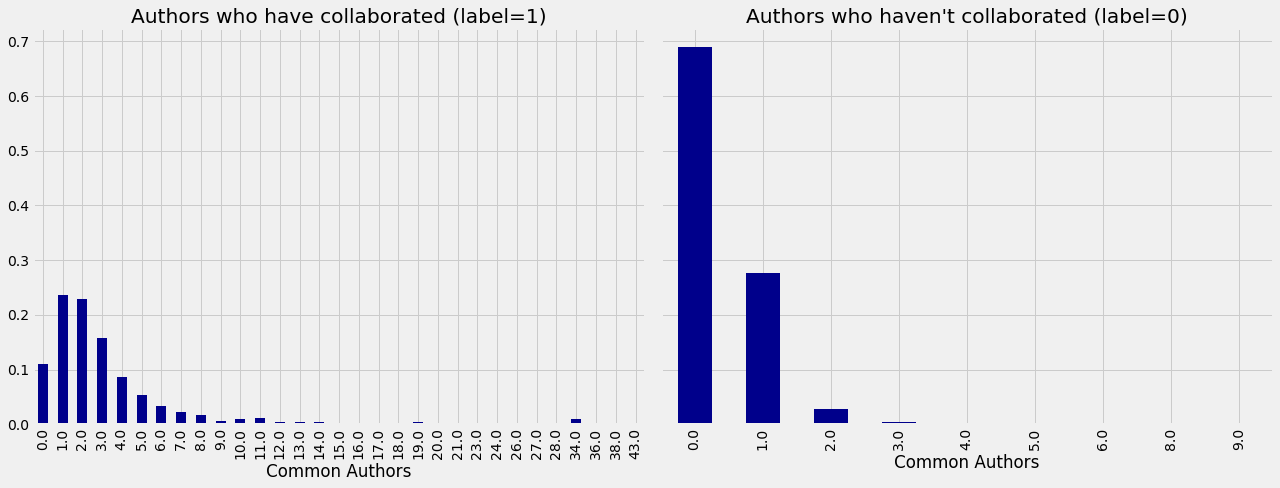

In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  common_authors = filtered.toPandas()["commonAuthors"]
  histogram = common_authors.value_counts().sort_index()
  histogram /= float(histogram.sum())
  histogram.plot(kind="bar", x='Common Authors', color="darkblue",
  ax=axs[index], title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Common Authors")
  
plt.tight_layout()
plt.show()

In [ ]:
def train_model(fields, training_data):
  pipeline = create_pipeline(fields)
  model = pipeline.fit(training_data)
  return model

In [ ]:
basic_model = train_model(["commonAuthors"], training_data)

In [ ]:
eval_df = spark.createDataFrame(
[(0,), (1,), (2,), (10,), (100,)],
['commonAuthors'])
(basic_model.transform(eval_df)
.select("commonAuthors", "probability", "prediction")
.show(truncate=False))

+-------------+-----------------------------------------+----------+
|commonAuthors|probability                              |prediction|
+-------------+-----------------------------------------+----------+
|0            |[0.7361464371641833,0.26385356283581674] |0.0       |
|1            |[0.7361464371641833,0.26385356283581674] |0.0       |
|2            |[0.049506733168664496,0.9504932668313355]|1.0       |
|10           |[0.049506733168664496,0.9504932668313355]|1.0       |
|100          |[0.049506733168664496,0.9504932668313355]|1.0       |
+-------------+-----------------------------------------+----------+



In [ ]:
def evaluate_model(model, test_data):
  # Execute the model against the test set
  predictions = model.transform(test_data)
  # Compute true positive, false positive, false negative counts
  tp = predictions[(predictions.label == 1) &
  (predictions.prediction == 1)].count()
  fp = predictions[(predictions.label == 0) &
  (predictions.prediction == 1)].count()
  fn = predictions[(predictions.label == 1) &
  (predictions.prediction == 0)].count()
  # Compute recall and precision manually
  recall = float(tp) / (tp + fn)
  precision = float(tp) / (tp + fp)
  # Compute accuracy using Spark MLLib's binary classification evaluator
  accuracy = BinaryClassificationEvaluator().evaluate(predictions)
  # Compute false positive rate and true positive rate using sklearn functions
  labels = [row["label"] for row in predictions.select("label").collect()]
  preds = [row["probability"][1] for row in predictions.select
  ("probability").collect()]
  fpr, tpr, threshold = roc_curve(labels, preds)
  roc_auc = auc(fpr, tpr)
  return { "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "accuracy": accuracy,
  "recall": recall, "precision": precision }

In [ ]:
def display_results(results):
  results = {k: v for k, v in results.items() if k not in
  ["fpr", "tpr", "roc_auc"]}
  return pd.DataFrame({"Measure": list(results.keys()),
  "Score": list(results.values())})

In [ ]:
basic_results = evaluate_model(basic_model, test_data)

In [ ]:
display_results(basic_results)

,Measure,Score
0,accuracy,0.851257
1,recall,0.740971
2,precision,0.950661


In [ ]:
def create_roc_plot():
  plt.style.use('classic')
  fig = plt.figure(figsize=(13, 8))
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.rc('axes', prop_cycle=(cycler('color',['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
  plt.plot([0, 1], [0, 1], linestyle='--', label='Random score(AUC = 0.50)')
  return plt, fig

def add_curve(plt, title, fpr, tpr, roc):
  plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")

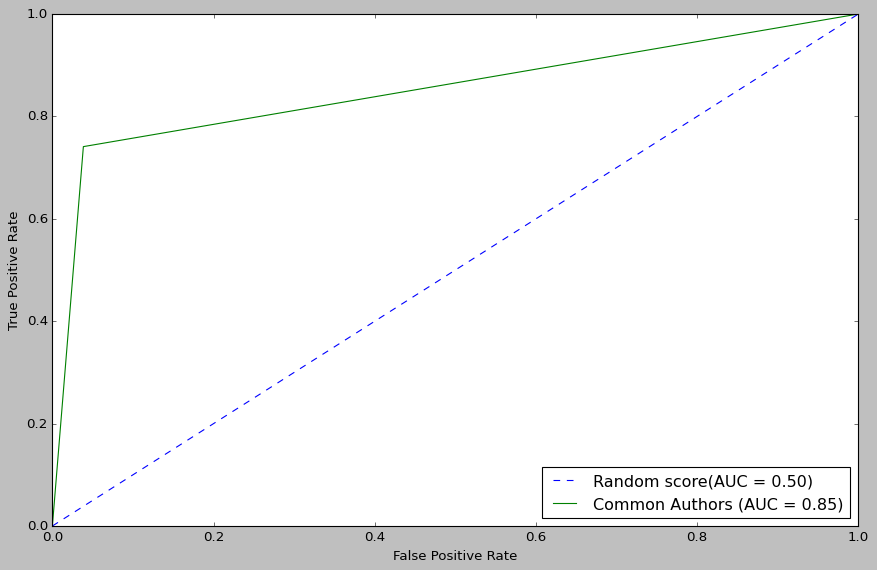

In [ ]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

In [ ]:
(training_data.filter(training_data["label"]==1).describe().select("summary", "commonAuthors", "prefAttachment", "totalNeighbours", "sim_score_cos").show())

(training_data.filter(training_data["label"]==0).describe().select("summary", "commonAuthors", "prefAttachment", "totalNeighbours", "sim_score_cos").show())

+-------+-----------------+------------------+-----------------+------------------+
|summary|    commonAuthors|    prefAttachment|  totalNeighbours|     sim_score_cos|
+-------+-----------------+------------------+-----------------+------------------+
|  count|            67364|             67364|            67364|             67364|
|   mean| 3.15061457158126| 59.31528709696574|9.724778813609642|0.5439591798839405|
| stddev|4.126062073364245|156.88968711686508|8.202316280044707|0.3678249177056048|
|    min|              0.0|               1.0|              2.0|               0.0|
|    max|             43.0|            2640.0|             79.0|1.0000001192092896|
+-------+-----------------+------------------+-----------------+------------------+

+-------+-------------------+-----------------+------------------+-------------------+
|summary|      commonAuthors|   prefAttachment|   totalNeighbours|      sim_score_cos|
+-------+-------------------+-----------------+------------------+---

In [ ]:
# FOS model

In [ ]:
fields = ["commonAuthors", "sim_score_cos"]
fos_model = train_model(fields, training_data)

In [ ]:
fos_results = evaluate_model(fos_model, test_data)
display_results(fos_results)

,Measure,Score
0,accuracy,0.949560
1,recall,0.907472
2,precision,0.926998


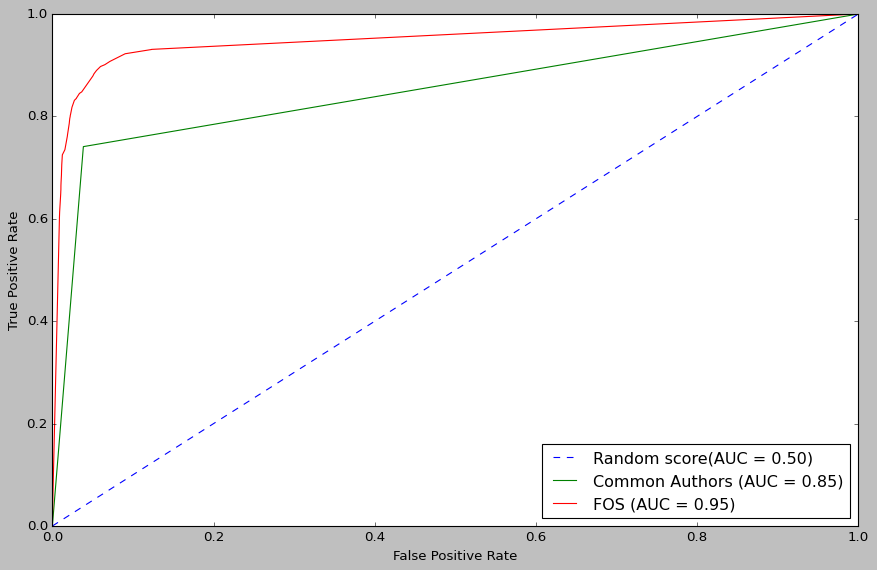

In [ ]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"],basic_results["roc_auc"])
add_curve(plt, "FOS",fos_results["fpr"], fos_results["tpr"],fos_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

In [ ]:
def plot_feature_importance(fields, feature_importances):
  df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
  df = df.sort_values("Importance", ascending=False)
  ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
  ax.xaxis.set_label_text("")
  plt.tight_layout()
  plt.show()

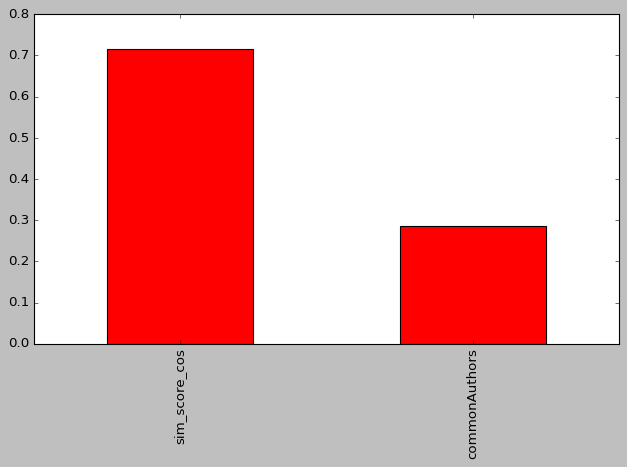

In [ ]:
rf_model = fos_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

In [ ]:
# Graphy model

In [ ]:
fields = ["commonAuthors", "sim_score_cos", "prefAttachment", "totalNeighbours"]
graphy_model = train_model(fields, training_data)

In [ ]:
graphy_results = evaluate_model(graphy_model, test_data)
display_results(graphy_results)

,Measure,Score
0,accuracy,0.979542
1,recall,0.920279
2,precision,0.944850


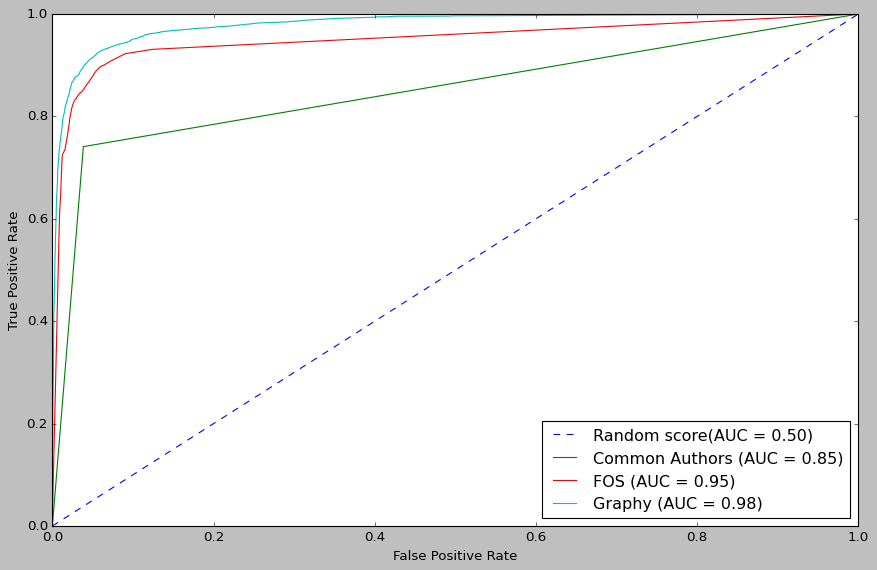

In [ ]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"],basic_results["roc_auc"])
add_curve(plt, "FOS",fos_results["fpr"], fos_results["tpr"],fos_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

In [ ]:
def plot_feature_importance(fields, feature_importances):
  df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
  df = df.sort_values("Importance", ascending=False)
  ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
  ax.xaxis.set_label_text("")
  plt.tight_layout()
  plt.show()

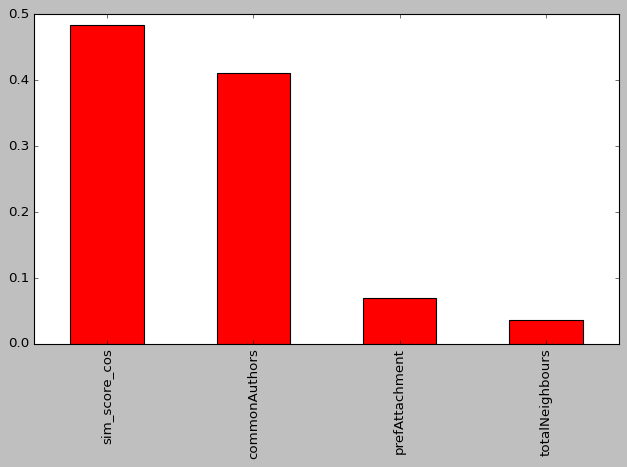

In [ ]:
rf_model = graphy_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

In [ ]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]])
  AS minTriangles,
  apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]])
  AS maxTriangles,
  apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]])
  AS minCoefficient,
  apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]])
  AS maxCoefficient
  """
  params = {
  "pairs": [{"node1": row["node1"], "node2": row["node2"]}
  for row in data.collect()],
  "trianglesProp": triangles_prop,
  "coefficientProp": coefficient_prop
  }
  features = spark.createDataFrame(graph.run(query, params).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [ ]:
training_data = apply_triangles_features(training_data,"trianglesTrain", "coefficientTrain")

In [ ]:
training_data.show(n=5)

+-----+------+-----+-------------+--------------+---------------+------------------+------------+------------+--------------------+-------------------+
|node1| node2|label|commonAuthors|prefAttachment|totalNeighbours|     sim_score_cos|minTriangles|maxTriangles|      minCoefficient|     maxCoefficient|
+-----+------+-----+-------------+--------------+---------------+------------------+------------+------------+--------------------+-------------------+
|   39|263110|    0|          0.0|         294.0|           35.0|               0.0|           9|          14| 0.06666666666666667| 0.0989010989010989|
|   68|   398|    0|          0.0|         108.0|           31.0|               0.0|           2|          13|0.037037037037037035| 0.3333333333333333|
|  109|  1132|    0|          1.0|         120.0|           22.0|0.1539956033229828|           6|           9| 0.08571428571428572|0.21428571428571427|
|  128|     6|    1|          1.0|          15.0|            7.0|0.0803954005241394|    

In [ ]:
test_data = apply_triangles_features(test_data,"trianglesTest", "coefficientTest")

In [ ]:
(training_data.filter(training_data["label"]==1).describe().select("summary", "minTriangles", "maxTriangles","minCoefficient", "maxCoefficient").show())

(training_data.filter(training_data["label"]==0).describe().select("summary", "minTriangles", "maxTriangles", "minCoefficient","maxCoefficient").show())

+-------+------------------+-----------------+------------------+------------------+
|summary|      minTriangles|     maxTriangles|    minCoefficient|    maxCoefficient|
+-------+------------------+-----------------+------------------+------------------+
|  count|             67364|            67364|             67364|             67364|
|   mean|14.439032717772104|21.01414702214833|0.5245824173609503|0.7908323884830792|
| stddev|57.921844583673604|66.30434363267307|0.3791096130381265|0.3348353645932572|
|    min|                 0|                0|               0.0|               0.0|
|    max|               598|              779|               1.0|               1.0|
+-------+------------------+-----------------+------------------+------------------+

+-------+------------------+------------------+------------------+------------------+
|summary|      minTriangles|      maxTriangles|    minCoefficient|    maxCoefficient|
+-------+------------------+------------------+---------------

In [ ]:
fields = ["commonAuthors", "sim_score_cos", "prefAttachment", "totalNeighbours","minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient"]
triangle_model = train_model(fields, training_data)

In [ ]:
triangle_results = evaluate_model(triangle_model, test_data)
display_results(triangle_results)

,Measure,Score
0,accuracy,0.987568
1,recall,0.932130
2,precision,0.957368


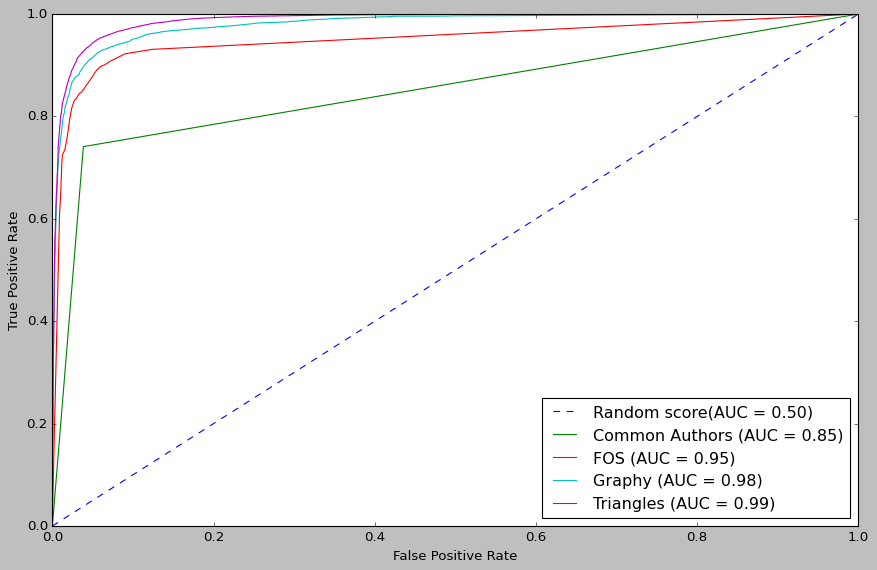

In [ ]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "FOS",fos_results["fpr"], fos_results["tpr"], fos_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
add_curve(plt, "Triangles",triangle_results["fpr"], triangle_results["tpr"],triangle_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

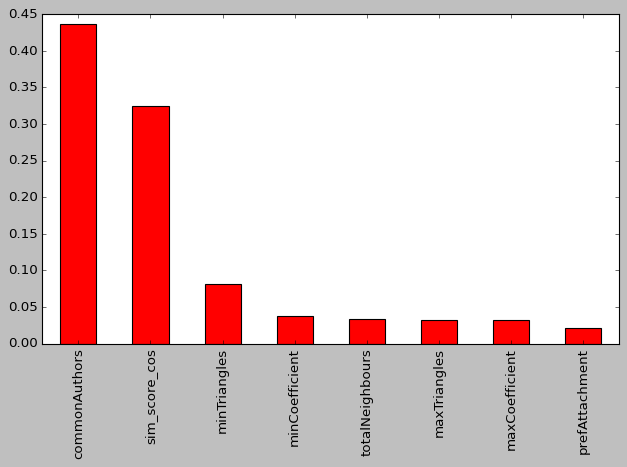

In [ ]:
rf_model = triangle_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

In [ ]:
# Community

In [ ]:
def apply_community_features(data, partition_prop, louvain_prop):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN
  1 ELSE 0 END AS samePartition,
  CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN
  1 ELSE 0 END AS sameLouvain
  """
  params = {"pairs": [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()],"partitionProp": partition_prop,"louvainProp": louvain_prop}
  features = spark.createDataFrame(graph.run(query, params).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [ ]:
training_data = apply_community_features(training_data,"partitionTrain", "louvainTrain")

In [ ]:
training_data.show(n=5)

+-----+------+-----+-------------+--------------+---------------+------------------+------------+------------+--------------------+-------------------+-------------+-----------+
|node1| node2|label|commonAuthors|prefAttachment|totalNeighbours|     sim_score_cos|minTriangles|maxTriangles|      minCoefficient|     maxCoefficient|samePartition|sameLouvain|
+-----+------+-----+-------------+--------------+---------------+------------------+------------+------------+--------------------+-------------------+-------------+-----------+
|   39|263110|    0|          0.0|         294.0|           35.0|               0.0|           9|          14| 0.06666666666666667| 0.0989010989010989|            0|          0|
|   68|   398|    0|          0.0|         108.0|           31.0|               0.0|           2|          13|0.037037037037037035| 0.3333333333333333|            0|          0|
|  109|  1132|    0|          1.0|         120.0|           22.0|0.1539956033229828|           6|           9|

In [ ]:
test_data = apply_community_features(test_data, "partitionTest", "louvainTest")

In [ ]:
import pyspark.sql.functions as F

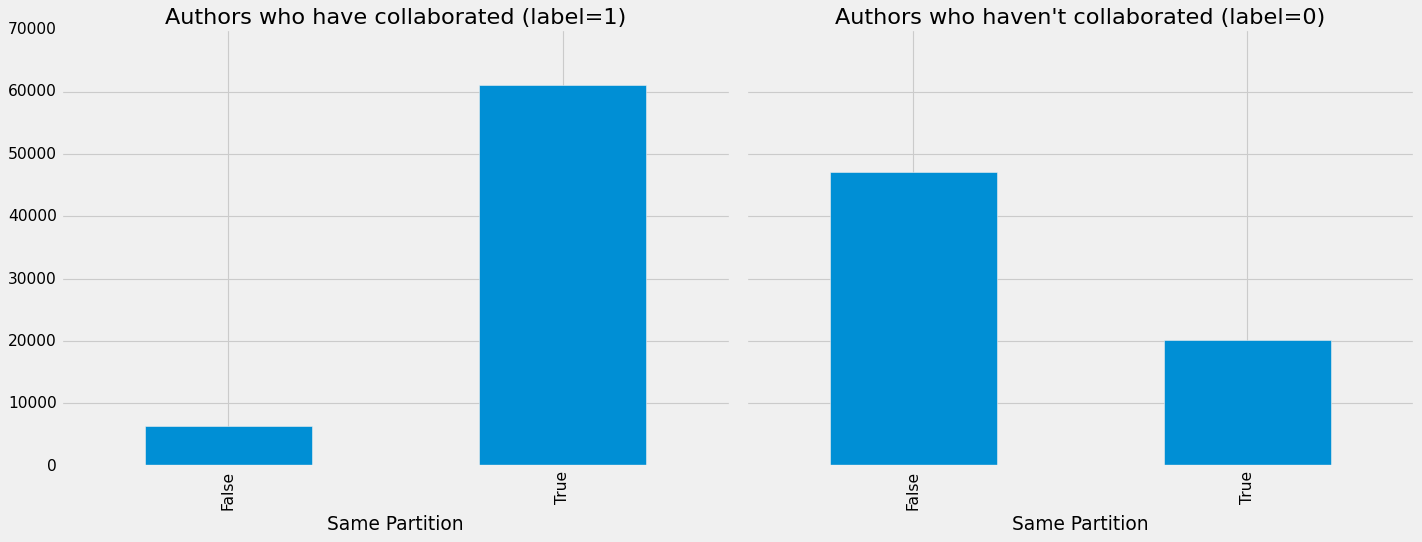

In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  values = (filtered.withColumn('samePartition',
  F.when(F.col("samePartition") == 0, "False")
  .otherwise("True"))
  .groupby("samePartition")
  .agg(F.count("label").alias("count"))
  .select("samePartition", "count")
  .toPandas())
  values.set_index("samePartition", drop=True, inplace=True)
  values.plot(kind="bar", ax=axs[index], legend=None,
  title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Same Partition")

plt.tight_layout()
plt.show()

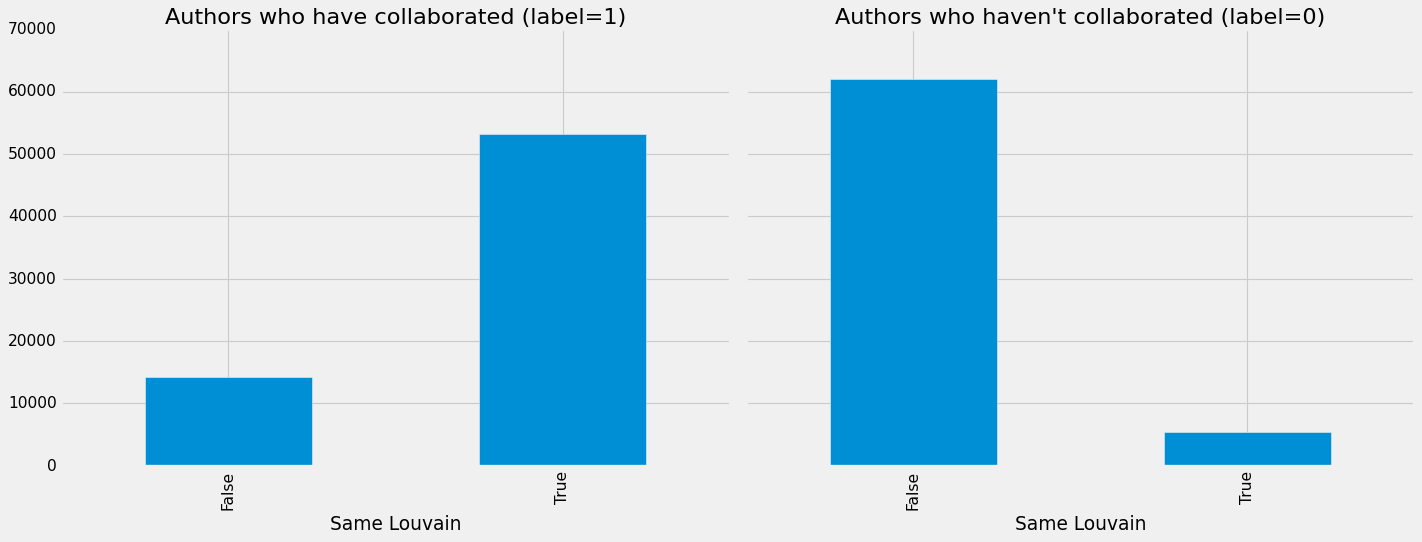

In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  values = (filtered.withColumn('sameLouvain',
  F.when(F.col("sameLouvain") == 0, "False")
  .otherwise("True"))
  .groupby("sameLouvain")
  .agg(F.count("label").alias("count"))
  .select("sameLouvain", "count")
  .toPandas())
  values.set_index("sameLouvain", drop=True, inplace=True)
  values.plot(kind="bar", ax=axs[index], legend=None,
  title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Same Louvain")
  
plt.tight_layout()
plt.show()

In [ ]:
fields = ["commonAuthors", "sim_score_cos", "prefAttachment", "totalNeighbours","minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient","samePartition", "sameLouvain"]
community_model = train_model(fields, training_data)

In [ ]:
community_results = evaluate_model(community_model, test_data)
display_results(community_results)

,Measure,Score
0,accuracy,0.991258
1,recall,0.955796
2,precision,0.961846


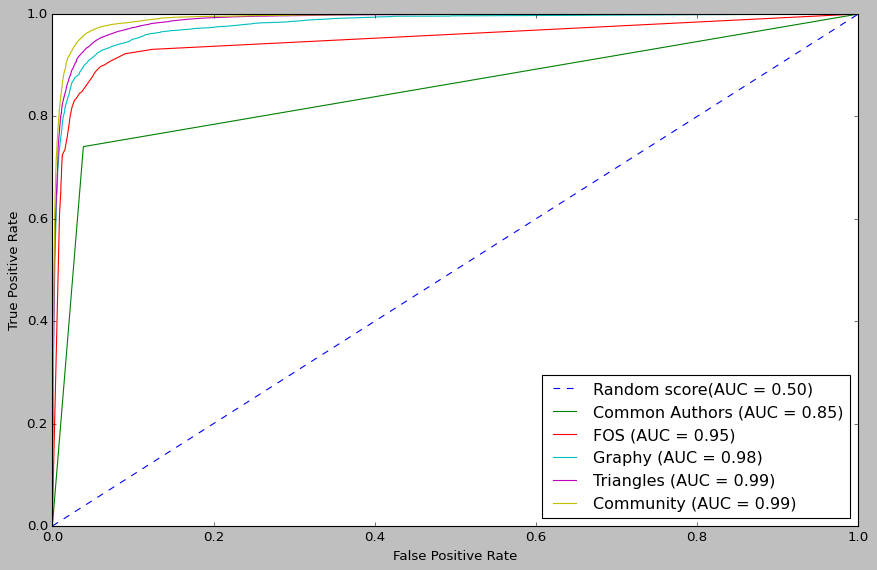

In [ ]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "FOS",fos_results["fpr"], fos_results["tpr"], fos_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
add_curve(plt, "Triangles",triangle_results["fpr"], triangle_results["tpr"],triangle_results["roc_auc"])
add_curve(plt, "Community",community_results["fpr"], community_results["tpr"],community_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

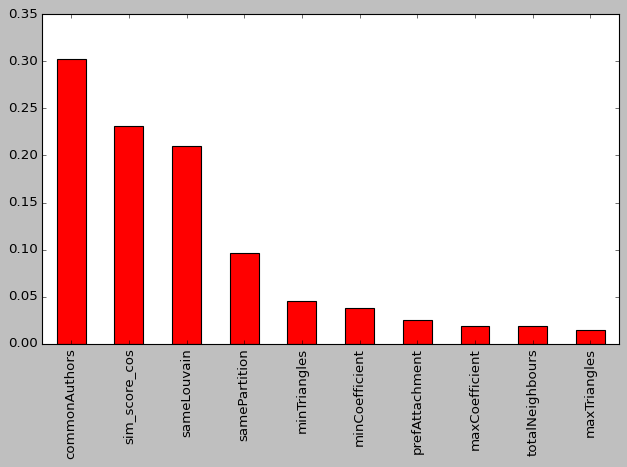

In [ ]:
rf_model = community_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

In [ ]:
# Save the models

In [ ]:
!ls models

In [ ]:
basic_model.save("/content/gdrive/MyDrive/pyspark_models/basic_cn")
fos_model.save("/content/gdrive/MyDrive/pyspark_models/fos")
graphy_model.save("/content/gdrive/MyDrive/pyspark_models/graphy")
triangle_model.save("/content/gdrive/MyDrive/pyspark_models/triangle")
community_model.save("/content/gdrive/MyDrive/pyspark_models/comm")